# Generate pileup data for ATLAS using a GAN (Generative Adversarial Network)

In [1]:
#imports
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
#from tensorflow.image import decode_jpeg
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.gridspec as gridspec
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
from matplotlib.colors import LogNorm
from atlasgan import reco
from atlasgan import keras_gan as gan
from atlasgan import train, dcgan

Using TensorFlow backend.


## Only have to run these cell once, then just skip over it and load next cell every other time

In [2]:
# normalization_constant = 487

# #load in the data
# local_path = os.getcwd()
# file_path = "/towahid/mu20_normalized_train.npy"
# data_path = local_path + file_path
# data_norm = np.load(data_path)

# data_full = np.multiply(data_norm, normalization_constant)
# jets_full = reco.reconstruct_events(data_full)

# export_csv = jets_full.to_csv(r'/home/wyattblair/working_jets.csv', index = None, header = True)
# np.save("working_train", data_full)
# np.save("working_normalized_train", data_norm)

# --------------------------------------------------------

In [3]:
local_path = os.getcwd()
file_name1 = "/working_train.npy"
file_name2 = "/working_normalized_train.npy"
file_name3 = "/working_jets.csv"
data_path = local_path + file_name1
data_norm_path = local_path + file_name2
jets_path = local_path + file_name3

data_full = np.load(data_path)
data_norm = np.load(data_norm_path)
jets = pd.read_csv(jets_path)

## Let's plot some of the training data

In [4]:
#Wahid's draw_image function
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

### Plot Individual Events

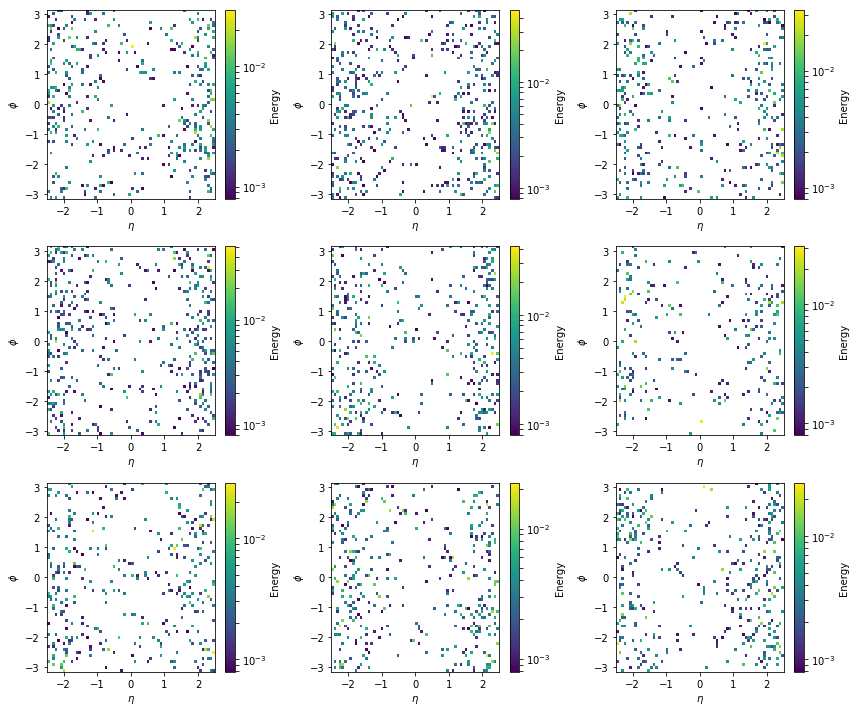

In [5]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
sample_seed = 2
sample_events = []
for i in range(sample_seed, sample_seed+9):
    sample_events.append(data_norm[i])

#Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(np.absolute(sample_events[i]), ax=ax)
plt.tight_layout()

### Plot the properties of the jets

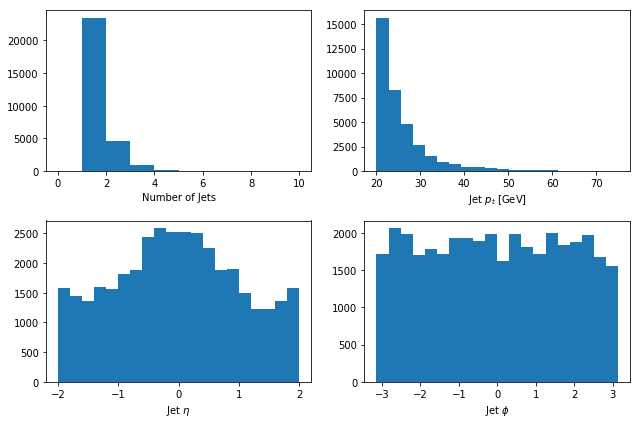

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
jetCount = jets.groupby('event').size()
ax1.hist(jetCount, bins=10, range=(0,10))
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(jets.pt, bins=20, range=(20,75))
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(jets.eta, bins= 20, range=(-2,2))
ax3.set_xlabel('Jet $\eta$')

#jet phi
ax4.hist(jets.phi, bins= 20, range= (-np.pi, np.pi))
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()


<Figure size 432x288 with 0 Axes>

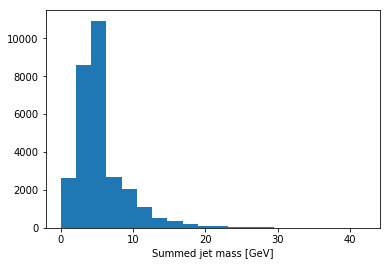

<Figure size 432x288 with 0 Axes>

In [7]:
# Sum of jet mass
sumMass = jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(sumMass, bins=20)
plt.xlabel('Summed jet mass [GeV]');

plt.figure()

## Let's start training the model

### Keras

In [22]:
Model = gan.GAN(data_norm)

BUILDING DISCRIMINATOR======>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 94)        940       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 94)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 94)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 188)       159236    
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 17, 17, 188)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 17, 17, 188)       752       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 17, 17, 18

In [ ]:
Model.train(steps = 100)
# Model.sample_images(epoch=2)

Training data shape:  <type 'numpy.ndarray'>
Training data shape:  (160000, 64, 64, 1)
Training data min:  0.0
Training data max:  1.0
0 [D loss: 4.773849, acc.: 19.53%] [G loss: 1.628752]
1 [D loss: 1.840320, acc.: 55.86%] [G loss: 0.000978]
2 [D loss: 8.584077, acc.: 18.75%] [G loss: 0.062760]
3 [D loss: 0.113465, acc.: 96.48%] [G loss: 0.244504]
4 [D loss: 7.136358, acc.: 48.83%] [G loss: 0.000541]
5 [D loss: 1.660616, acc.: 50.78%] [G loss: 16.085352]
6 [D loss: 0.301090, acc.: 91.02%] [G loss: 16.118095]
7 [D loss: 0.020729, acc.: 99.61%] [G loss: 16.118095]
8 [D loss: 0.000036, acc.: 100.00%] [G loss: 16.056757]
9 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.337858]
10 [D loss: 0.335806, acc.: 96.09%] [G loss: 0.549148]
11 [D loss: 0.472770, acc.: 87.89%] [G loss: 10.783124]
12 [D loss: 0.000508, acc.: 100.00%] [G loss: 5.119797]
13 [D loss: 13.816790, acc.: 0.00%] [G loss: 6.642376]
14 [D loss: 8.059089, acc.: 50.00%] [G loss: 5.471589]
15 [D loss: 8.059158, acc.: 50.00%] [G lo

In [10]:
num_gen_events = 10**5
noise = np.random.normal(0, 1, (num_gen_events, 64))
gen_imgs_norm = Model.generator.predict(noise)

### Tensforflow

In [11]:
# Model = dcgan.dcgan()

In [12]:
# # config:
# flags = tf.app.flags
# tf.app.flags.DEFINE_string('f', '', 'kernel')
# flags.DEFINE_string("dataset", "cosmo", "The name of dataset [cosmo]")
# flags.DEFINE_string("datafile", "data/cosmo_primary_64_1k_train.npy", "Input data file for cosmo")
# flags.DEFINE_integer("epoch", 0, "Epoch to train [0]")
# flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
# flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
# flags.DEFINE_float("flip_labels", 0.01, "Probability of flipping labels [0.01]")
# flags.DEFINE_integer("z_dim", 100, "Dimension of noise vector z [100]")
# flags.DEFINE_integer("nd_layers", 4, "Number of discriminator convolutional layers. [4]")
# flags.DEFINE_integer("ng_layers", 4, "Number of generator conv_T layers. [4]")
# flags.DEFINE_integer("gf_dim", 64, "Dimension of gen filters in last conv layer. [64]")
# flags.DEFINE_integer("df_dim", 64, "Dimension of discrim filters in first conv layer. [64]")
# flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
# flags.DEFINE_integer("output_size", 64, "The size of the output images to produce [64]")
# flags.DEFINE_integer("c_dim", 1, "Dimension of image color. [1]")
# flags.DEFINE_string("data_format", "NHWC", "data format [NHWC]")
# flags.DEFINE_boolean("transpose_matmul_b", False, "Transpose matmul B matrix for performance [False]")
# flags.DEFINE_string("checkpoint_dir", "checkpoints", "Directory name to save the checkpoints [checkpoint]")
# flags.DEFINE_string("experiment", "run_0", "Tensorboard run directory name [run_0]")
# flags.DEFINE_boolean("save_every_step", False, "Save a checkpoint after every step [False]")
# flags.DEFINE_boolean("verbose", True, "print loss on every step [False]")
# config = flags.FLAGS

In [13]:
# train.train_dcgan(data_norm, config)

In [14]:
# #load in tf sample images
# gen_imgs_norm = np.load("/home/wyattblair/tensorflow_samples/tensorflow_samples-50.npy")
# count = 0
# for event in gen_imgs_norm:
#     if count% 100 == 0:
#         print(count)
#     count+=1
#     for i in range(len(event)):
        
#         for j in range(len(event[0])):
#             for k in range(len(event[0][0])):
#                 if event[i][j][k] <= 0.001:
#                     event[i][j][k] = 0

# Un-normalize generated data:

In [15]:
normalization_constant = 487
gen_imgs_full = np.multiply(gen_imgs_norm, normalization_constant)
gen_jets = reco.reconstruct_events(gen_imgs_full)

# #Save normalized data/jets for later

# np.save('working_gen_data.npy', gen_imgs)
# export_csv = gen_jets.to_csv(r'/home/wyattblair/working_gen_jets.csv', index = None, header = True) 

In [16]:
# Load saved data/jets if you want

# gen_imgs = np.load(local_path + '/working_gen_data.npy')
# gen_jets = pd.read_csv(local_path + '/working_gen_jets.csv')

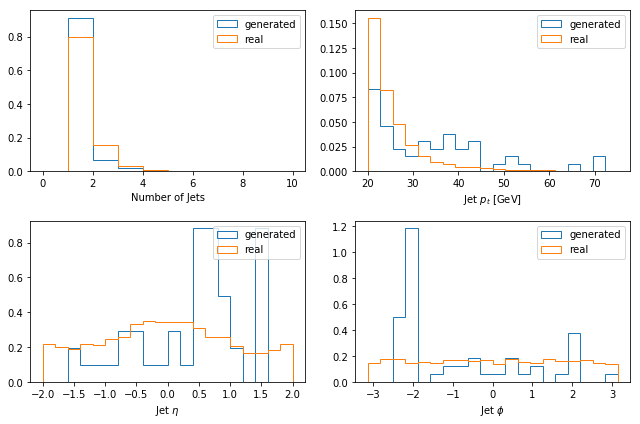

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
gen_jetCount = gen_jets.groupby('event').size()
count, binning, patches = ax1.hist(gen_jetCount, label = "generated", bins=10, range=(0,10), histtype='step', normed=True)
ax1.hist(jetCount, label = "real", bins=binning, histtype='step', normed=True)
ax1.legend(loc=0)
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(gen_jets.pt, label="generated", bins=20, range=(20,75), normed = True, histtype='step')
ax2.hist(jets.pt, label="real", bins=20, range=(20,75), normed = True, histtype='step')
ax2.legend(loc=0)
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(gen_jets.eta, label="generated", bins= 20, range=(-2,2), histtype='step', normed=True)
ax3.hist(jets.eta, label="real", bins=20, range=(-2,2), histtype='step', normed=True)
ax3.legend(loc=0)
ax3.set_xlabel('Jet $\eta$')


#jet phi
ax4.hist(gen_jets.phi, label = "generated", bins= 20, range= (-np.pi, np.pi), histtype='step', normed=True)
ax4.hist(jets.phi, label="real", bins=20, range= (-np.pi, np.pi), histtype='step', normed=True)
ax4.legend(loc=0)
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

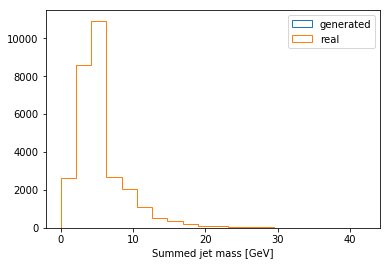

<Figure size 432x288 with 0 Axes>

In [25]:
# Sum of jet mass
gen_sumMass = gen_jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(gen_sumMass, label ="generated", bins=20, histtype='step')
plt.hist(sumMass, label="real",bins=20, histtype='step')
plt.xlabel('Summed jet mass [GeV]');
plt.legend(loc=0)

plt.figure()

In [19]:
#Stil TODO: Add the 2d convolutional layer in a manner that doesn't break the file

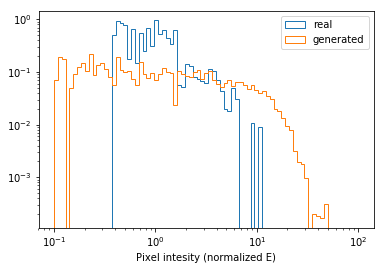

In [39]:
# Plot histogram of pixel intensities

plt.hist(data_full.flatten()[0:1000],  bins=10**np.linspace(-1, 2, 80), normed=True,label='real', histtype='step')
plt.hist(gen_imgs_full.flatten(),  bins=10**np.linspace(-1, 2, 80), normed=True,label='generated', histtype='step')
plt.xlabel('Pixel intesity (normalized E)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)

In [38]:
print(data_full.flatten()[0:1000])

[ 0.          0.          0.          0.          4.17872976  0.
  0.          1.63350632  0.          0.          1.1410744   1.17811414
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          5.81164914  0.
  0.          2.21924412  0.          1.393835    0.          0.
  0.          1.56561507  0.          0.50095128  0.          0.
  0.          0.          0.          3.62171252  0.          0.
  0.          0.          0.          0.          0.          0.
  3.98866758  0.          0.60092927  0.          0.          0.
  0.          1.09614549  0.          4.69147409  0.          2.49273547
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.98592923  0.
  0.          0.          0.          0.          0.          0.
  0.          0.6039837   0.          3.00478069  0.          0.
  0.          0.          1.00605531  0.          5.85074237  6.2848101
  

In [21]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
gen_sample_seed = 121
gen_sample_events = []

for i in range(gen_sample_seed, gen_sample_seed+9):
    gen_sample_events.append(gen_imgs_full[i])

for event in gen_sample_events:
    for i in range(len(event)):
        for j in range(len(event[0])):
            for k in range(len(event[0][0])):
                if event[i][j][k] <= 0.001:
                    event[i][j][k] = 0


# #Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(np.absolute(gen_sample_events[i].squeeze()), ax=ax)
plt.tight_layout()

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function post_execute at 0x7fd65e60c7d0> (for post_execute):


ValueError: values must all be positive

ValueError: values must all be positive

<Figure size 864x720 with 11 Axes>

In [ ]:
print("len(gen_jets): ", len(gen_jets))
print("sum(jetCount), sum(gen_jetCount), len(jetCount), len(gen_jetCount): ", sum(jetCount), sum(gen_jetCount), len(jetCount), len(gen_jetCount))
print("sum(gen_jets.eta): ", sum(gen_jets.eta))
print("max(gen_jetCount): ", max(gen_jetCount))
print(gen_imgs_norm.shape)

In [ ]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
gen_sample_events = []

for i in range(9):
    temp_file = np.load('/home/wyattblair/tensorflow_samples/tensorflow_samples-' + str(int((i+1) * 50/9)) + '.npy')
    gen_sample_events.append(temp_file[0])


for event in gen_sample_events:
    for i in range(len(event)):
        for j in range(len(event[0])):
            for k in range(len(event[0][0])):
                if event[i][j][k] <= 0.001:
                    event[i][j][k] = 0


#Plot the events stored in sample_events using draw_image
count = int(50/9)

fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    
    draw_image(np.absolute(gen_sample_events[i].squeeze()), ax=ax)
    
plt.tight_layout()